In [2]:
import numpy as np
from keras.layers import LSTM, Bidirectional, Dense, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [32]:
NB_LSTM_CELLS = 256
NB_DENSE_CELLS = 128
EMBEDDING_SIZE = 100

In [33]:
def make_bidirectional_lstm_model(num_input_tokens, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=num_input_tokens, output_dim=EMBEDDING_SIZE, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(units=NB_LSTM_CELLS, dropout=0.2, recurrent_dropout=0.2, input_shape=(max_len, EMBEDDING_SIZE))))
    model.add(Dense(NB_DENSE_CELLS, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # output layer with two nodes for malicious and safe URL prediction

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
class LSTMPredictor(object):
    
    model_name = 'lstm_url_predictor'
    
    def __init__(self):
        self.model = None
        self.num_input_tokens = None
        self.idx2char = None
        self.char2idx = None
        self.max_url_seq_length = None
        
    @staticmethod
    def get_config_file_path(model_dir_path):
        return model_dir_path + '/' + LSTMPredictor.model_name + '-config.npy'

    @staticmethod
    def get_weight_file_path(model_dir_path):
        return model_dir_path + '/' + LSTMPredictor.model_name + '-weights.h5'

    @staticmethod
    def get_architecture_file_path(model_dir_path):
        return model_dir_path + '/' + LSTMPredictor.model_name + '-architecture.json'

    def load_model(self, model_dir_path):
        config_file_path = self.get_config_file_path(model_dir_path)
        weight_file_path  = self.get_weight_file_path(model_dir_path)
        
        # config file provides all information from preprocessing the data 

        config = np.load(config_file_path, allow_pickle=True).item()
        self.num_input_tokens = config['num_input_tokens']
        self.max_url_seq_length = config['max_url_seq_length']
        self.idx2char = config['idx2char']
        self.char2idx = config['char2idx']

        self.model = make_bidirectional_lstm_model(self.num_input_tokens, self.max_url_seq_length)
        self.model.load_weights(weight_file_path)  # loads trained model
        
    def predict(self, url):
        print("Given URL for prediction : ",url)
        data_size = 1
        X = np.zeros(shape=(data_size, self.max_url_seq_length))
        for idx, c in enumerate(url):
            if c in self.char2idx:
                X[0, idx] = self.char2idx[c]
        predicted = self.model.predict(X)[0]
        print("Output Layer : ",predicted)
        predicted_label = np.argmax(predicted)
        return predicted_label
    
    def extract_training_data(self, url_data):
        data_size = url_data.shape[0]
        X = np.zeros(shape=(data_size, self.max_url_seq_length))
        Y = np.zeros(shape=(data_size, 2))
        for i in range(data_size):
            url = url_data['text'][i]
            label = url_data['label'][i]
            for idx, c in enumerate(url):
                X[i, idx] = self.char2idx[c]
            Y[i, label] = 1

        return X, Y
    
    def fit(self, text_model, url_data, model_dir_path, batch_size=None, epochs=None,
            test_size=None, random_state=None):
        if batch_size is None:
            batch_size = 64
        if epochs is None:
            epochs = 30
        if test_size is None:
            test_size = 0.2
        if random_state is None:
            random_state = 42

            
        # get all essential variables and assets from text model
        self.num_input_tokens = text_model['num_input_tokens']
        self.char2idx = text_model['char2idx']
        self.idx2char = text_model['idx2char']
        self.max_url_seq_length = text_model['max_url_seq_length']

        np.save(self.get_config_file_path(model_dir_path), text_model)

        weight_file_path = self.get_weight_file_path(model_dir_path)

        checkpoint = ModelCheckpoint(weight_file_path)

        X, Y = self.extract_training_data(url_data)

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=test_size, random_state=random_state)

        self.model = make_bidirectional_lstm_model(self.num_input_tokens, self.max_url_seq_length)
        
        print(self.model.summary())

        with open(self.get_architecture_file_path(model_dir_path), 'wt') as f:
            f.write(self.model.to_json())

        history = self.model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=1,
                                 validation_data=(Xtest, Ytest), callbacks=[checkpoint])

        self.model.save_weights(weight_file_path)

        np.save(model_dir_path + '/' + LSTMPredictor.model_name + '-history.npy', history.history)

        return history

In [50]:
def load_url_data(data_dir_path):
    url_data = pd.read_csv(data_dir_path + os.path.sep + 'URL.txt', sep=',')

    url_data.columns = ['text', 'label']

    class_zero = url_data[url_data['label'] == 0].reset_index()
    class_one = url_data[url_data['label'] == 1].reset_index()

    class_zero = class_zero.truncate(before=1, after=class_one.shape[0]) # balancing classes

    url_data = pd.concat([class_zero, class_one])
    url_data = url_data.sample(frac=1.0).reset_index()

    return url_data

In [51]:
# load the url data from the csv file
import pandas as pd
import os
url_data = load_url_data('./data')
url_data

,level_0,index,text,label
0,30,30,http://google.com.br,0
1,131,180,http://renren.com,0
2,111,638,http://borderline.asia.com,1
3,120,647,http://e-shopping.asia.com,1
4,46,146,http://secure.googledrive.com.iphoneturkish.co...,1
...,...,...,...,...
655,31,131,http://ba.dabed1.client.atlantech.net/modules/...,1
656,15,15,http://yandex.ru,0
657,8,8,http://twitter.com,0
658,112,161,http://w3schools.com,0


In [52]:
def extract_text_model(urls):
    char2idx = dict()
    max_url_seq_length = 0
    for url in urls:
        max_url_seq_length = max(max_url_seq_length, len(url))
        for c in url:
            if c not in char2idx:
                char2idx[c] = len(char2idx)
    num_input_tokens = len(char2idx)
    idx2char = dict([(idx, c) for c, idx in char2idx.items()])

    config = dict()
    config['num_input_tokens'] = num_input_tokens
    config['char2idx'] = char2idx
    config['idx2char'] = idx2char
    config['max_url_seq_length'] = max_url_seq_length

    return config

In [53]:
# use the urls to process them into distinct chars/index dicts and find max length of urls, total unique char tokens

text_model = extract_text_model(url_data['text'])
text_model

{'num_input_tokens': 67,
 'char2idx': {'h': 0,
  't': 1,
  'p': 2,
  ':': 3,
  '/': 4,
  'g': 5,
  'o': 6,
  'l': 7,
  'e': 8,
  '.': 9,
  'c': 10,
  'm': 11,
  'b': 12,
  'r': 13,
  'n': 14,
  'd': 15,
  'i': 16,
  'a': 17,
  's': 18,
  '-': 19,
  'u': 20,
  'v': 21,
  'k': 22,
  'w': 23,
  'G': 24,
  '%': 25,
  '2': 26,
  '0': 27,
  'S': 28,
  'f': 29,
  'y': 30,
  'j': 31,
  '(': 32,
  '?': 33,
  '<': 34,
  '!': 35,
  ')': 36,
  '3': 37,
  '6': 38,
  '7': 39,
  '9': 40,
  '5': 41,
  '8': 42,
  'x': 43,
  'z': 44,
  '1': 45,
  '4': 46,
  'C': 47,
  'L': 48,
  'D': 49,
  '=': 50,
  'A': 51,
  'O': 52,
  '_': 53,
  '&': 54,
  ';': 55,
  'R': 56,
  'B': 57,
  'q': 58,
  'U': 59,
  'I': 60,
  'K': 61,
  'P': 62,
  'N': 63,
  'V': 64,
  'E': 65,
  'Y': 66},
 'idx2char': {0: 'h',
  1: 't',
  2: 'p',
  3: ':',
  4: '/',
  5: 'g',
  6: 'o',
  7: 'l',
  8: 'e',
  9: '.',
  10: 'c',
  11: 'm',
  12: 'b',
  13: 'r',
  14: 'n',
  15: 'd',
  16: 'i',
  17: 'a',
  18: 's',
  19: '-',
  20: 'u',
  

In [54]:
import matplotlib.pyplot as plt

def create_history_plot(history, model_name):
    plt.title('Accuracy and Loss (' + model_name + ')')
    plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
    plt.plot(history.history['loss'], color='r', label='Train Loss')
    plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    
def plot_and_save_history(history, model_name, file_path):
    create_history_plot(history, model_name)
    plt.savefig(file_path)

## Training

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 281, 100)          6700      
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 281, 100)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 803,758
Trainable params: 803,758
Non-trainable params: 0
_________________________________________________________________
None
Train on 528 samples, validate on 132 samples
Epoch 1/75
528/528 [==============================] - 21s 40ms/

528/528 [==============================] - 27s 51ms/step - loss: 0.4432 - accuracy: 0.7860 - val_loss: 0.5476 - val_accuracy: 0.7576
Epoch 51/75
528/528 [==============================] - 25s 47ms/step - loss: 0.4389 - accuracy: 0.7936 - val_loss: 0.5733 - val_accuracy: 0.7121
Epoch 52/75
528/528 [==============================] - 26s 50ms/step - loss: 0.4276 - accuracy: 0.7841 - val_loss: 0.5481 - val_accuracy: 0.7576
Epoch 53/75
528/528 [==============================] - 26s 48ms/step - loss: 0.4072 - accuracy: 0.8049 - val_loss: 0.5681 - val_accuracy: 0.7500
Epoch 54/75
528/528 [==============================] - 23s 44ms/step - loss: 0.4133 - accuracy: 0.7803 - val_loss: 0.7006 - val_accuracy: 0.7424
Epoch 55/75
528/528 [==============================] - 22s 41ms/step - loss: 0.4179 - accuracy: 0.7992 - val_loss: 0.5571 - val_accuracy: 0.7500
Epoch 56/75
528/528 [==============================] - 20s 37ms/step - loss: 0.4039 - accuracy: 0.7955 - val_loss: 0.6790 - val_accuracy: 0.67

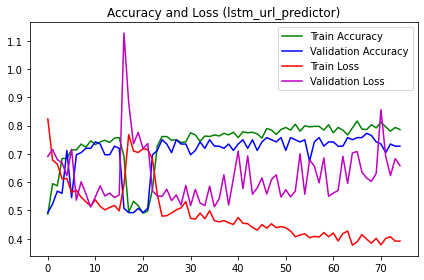

In [55]:
random_state = 42
np.random.seed(random_state)

data_dir_path = './data'
model_dir_path = './models'
report_dir_path = './reports'


batch_size = 64
epochs = 75

classifier = LSTMPredictor()

history = classifier.fit(text_model=text_model,
                         model_dir_path=model_dir_path,
                         url_data=url_data, batch_size=batch_size, epochs=epochs)

plot_and_save_history(history, LSTMPredictor.model_name,
                      report_dir_path + '/' + LSTMPredictor.model_name + '-history.png')

## Testing

In [57]:
predictor = LSTMPredictor()
predictor.load_model(model_dir_path)
url_data = load_url_data(data_dir_path)
count = 0
for url, label in zip(url_data['text'], url_data['label']):
    predicted_label = predictor.predict(url)
    print(url+'. predicted: ' + str(predicted_label) + ' actual: ' + str(label))
    count += 1
    if count > 20:
        break

Given URL for prediction :  http://urlmin.com
Output Layer :  [0.53449035 0.46550962]
http://urlmin.com. predicted: 0 actual: 1
Given URL for prediction :  http://stackoverflow.com
Output Layer :  [0.29493636 0.70506364]
http://stackoverflow.com. predicted: 1 actual: 0
Given URL for prediction :  http://civilwarvetswastate.com/gxy/
Output Layer :  [0.04078774 0.9592123 ]
http://civilwarvetswastate.com/gxy/. predicted: 1 actual: 1
Given URL for prediction :  http://swf.asia.com
Output Layer :  [0.0728371 0.9271629]
http://swf.asia.com. predicted: 1 actual: 1
Given URL for prediction :  http://bomberospuertomontt.cl/modules/0299970236/24185239539553/index2.php
Output Layer :  [0.04263825 0.9573618 ]
http://bomberospuertomontt.cl/modules/0299970236/24185239539553/index2.php. predicted: 1 actual: 1
Given URL for prediction :  http://neither.tv
Output Layer :  [0.5064952  0.49350473]
http://neither.tv. predicted: 0 actual: 1
Given URL for prediction :  http://ciquestudios.com
Output Layer :